# General Notebook

In [46]:
seed = 123
import os
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import random
import torch
random.seed(seed)     # python random generator
np.random.seed(seed)  # numpy random generator

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import cv2 



In [47]:

# Change the name to create or load the data and models
path = os.getcwd()
folder_data = r'Data\data_mlsp_semi'
#-------------------------------
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"  
print(device)

cpu


## Data

In [48]:
#--------------------------------------------
# 0: Vaquita girada
# 1: Cow     2: Human 
# 3: Horse   4: Camel
# 5: Dog1    6: Dog2
idx  = 1#! Id image
p = 40 #! porcentage of missing labels  options: [40, 60, 80, 100]
names = ['bull', 'cow', 'human', 'horse', 'camel', 'dog1', 'dog2']
name_image = names[idx]+str(p)
print(name_image)

cow40


In [49]:
#!  Pay attention to idx when we read the data 
x1 = plt.imread(os.path.join(path, folder_data, 'x{}.png'.format(idx+1)))
m, n = x1.shape
y_true = plt.imread(os.path.join(path, folder_data, 'y{}.png'.format(idx+1))).reshape(m*n, 1)
y1 =  np.load(os.path.join(path, folder_data, 'y_miss_{}.npy'.format(p)))[idx].reshape(m*n, 1)
x = torch.tensor(x1.reshape(m*n, 1), dtype=torch.float32)
y = torch.tensor(y1, dtype=torch.float32)
x = x.to(device)
y = y.to(device)

In [50]:
# general_path  = os.path.join(os.getcwd(), 'Results_save_models') #! Any
general_path = r'C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs' #! University
# general_path = r"C:\Users\katyt\Desktop\PhD\MLSP 2023\Results_save_models" #! Home
print('Saving our model in',general_path)
path_save = os.path.join(general_path, name_image)
if not os.path.exists(path_save):
    os.makedirs(path_save)

Saving our model in C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs


In [51]:
def img_save(im, val = 0):
    n, m = im.shape
    img = im.copy()+1
    img[n-1,m-1] = val
    return img
def img_missing(im, val = 0):
    n, m = im.shape
    img = im.copy()+1
    img[np.where(im==-1)] = val
    return img

# def img_save(im, val = 2):
#     n, m = im.shape
#     img = im.copy()
#     img[n-1,m-1] = val
#     return img
# def img_missing(im, val = 2):
#     n, m = im.shape
#     img = im.copy()
#     img[np.where(im==-1)] = val
#     return img

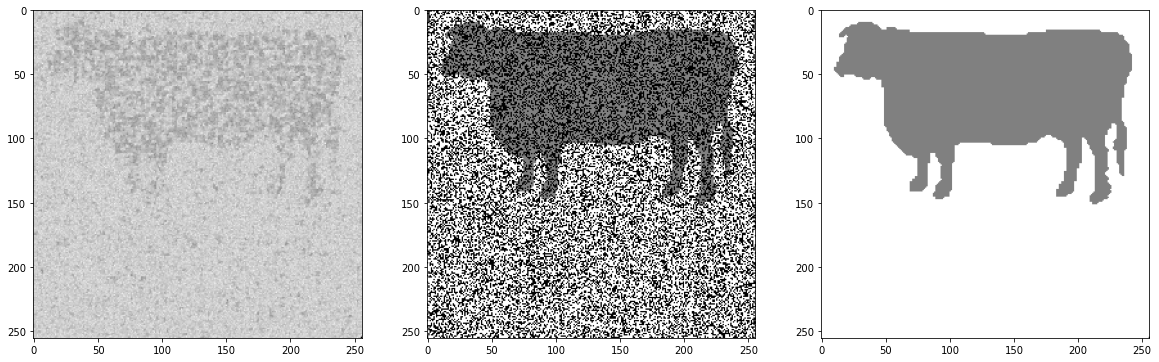

In [52]:
  
fig = plt.figure(figsize=(20, 30))  
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(img_save(x1), cmap='gray')
fig.add_subplot(rows, columns, 2)
plt.imshow(img_missing(y1.reshape(m,n)), cmap='gray')
fig.add_subplot(rows, columns, 3)
plt.imshow(img_save(y_true.reshape(m,n)), cmap='gray')

In [177]:
# cv2.imwrite(os.path.join(path_save,f'{name_image}_miss.png'), img_save(y1.reshape(m,n)*255))
# cv2.imwrite(os.path.join(path_save,f'{name_image}_label.png'), img_save(y_true.reshape(m,n)*255))


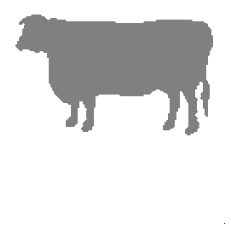

In [53]:
plt.imshow(img_save(x1), cmap='gray')
plt.axis('off')
plt.margins(x=0)
plt.savefig(os.path.join(path_save,f'{name_image}.png'), transparent=True, format='png', bbox_inches='tight', pad_inches=0)
plt.imshow(img_save(y1.reshape(m,n)), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(path_save,f'{name_image}_miss.png'),transparent=True,format='png', bbox_inches='tight', pad_inches=0)
plt.imshow(img_save(y_true.reshape(m,n)), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(path_save,f'{name_image}_label.png'),transparent=True,format='png', bbox_inches='tight', pad_inches=0)

## Functions and models

In [54]:
from models.SVRNN import SVRNN
from models.SVRNN_2 import SVRNN_2
from models.VSL import VSL
from models.TMM import TMM
from models.TMM_3 import TMM_3
from utils.training import *

# Trained Models

In [55]:
# General Parameters (we do not change the values of these parameters during the simulations)
x_dim = 1
y_dim = 1


## VLS

In [56]:
# Dimension of latent variables
z_dim = 1
h_dim = 14#None # This value is not necessary for the TMM model but we need to define it for TMM_3
num_neurons = 41
add_loss = False
#--------------------------------------------
model = VSL( x_dim, z_dim, y_dim, h_dim, num_neurons, device)
#--------------------------------------------
# Save models
#--------------------------------------------
model.to(device)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()

print(f'Actual path to save our models for {data} is \n {path_save} ')
# #* Initialization of the model in an specific epoch
model.to(device)
epoch_init = 100
model = model_reconstruction(model,epoch_init, path_save, device)




VSL has 5383 parameters to train
z_dim = 1, num_neurons = 41, h_dim = 14
Actual path to save our models for vsl is 
 C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs\cow40 
Actual  path for to initialize our models:  C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs\cow40
Initialization of the VSL model  at epoch 100
loss:  {tensor(10270.5498, requires_grad=True)} and epoch:  {100}


In [57]:
# #* Reconstruction
y_ = model.reconstruction(x,y)
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )

y_vls = y_.reshape(m,n).cpu().numpy()

cow40: VSL with  5383 parameters 
 after 100 has an error rate of 0.1564209479361922
 folder vsl


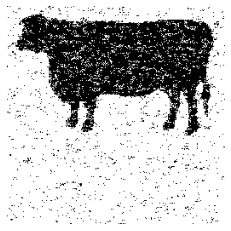

In [58]:

plt.imshow(img_save(y_vls), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(path_save,f'{name_image}_{data}.png'),transparent=True,format='png', bbox_inches='tight', pad_inches=0)

## TMM

In [61]:
# Dimension of latent variables
z_dim = 1
h_dim = 14#None # This value is not necessary for the TMM model but we need to define it for TMM_3
num_neurons = 25 #? == h_dim?
add_loss = True
#--------------------------------------------
model = TMM_3(x_dim, z_dim, y_dim, h_dim, num_neurons, device, add_loss)
#--------------------------------------------
# Save models
#--------------------------------------------
model.to(device)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()
print(f'Actual path to save our models for {data} is \n {path_save} ')
# #* Initialization of the model in an specific epoch
model.to(device)
epoch_init = 66
model = model_reconstruction(model,epoch_init, path_save, device)


TMM_3 has 5346 parameters to train
z_dim = 1, num_neurons = 25, h_dim = 14
Actual path to save our models for tmm_3 is 
 C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs\cow40 
Actual  path for to initialize our models:  C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs\cow40
Initialization of the TMM_3 model  at epoch 66
loss:  {tensor(-167924.6094, requires_grad=True)} and epoch:  {66}


### Reconstruction image

In [62]:
# #* Reconstruction
y_ = model.reconstruction(x,y)
# y_ = model.sample(x,y).cpu()
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )
y_tmm = y_.reshape(m,n).cpu().numpy()

cow40: TMM_3 with  5346 parameters 
 after 66 has an error rate of 0.019165295895336776
 folder tmm_3


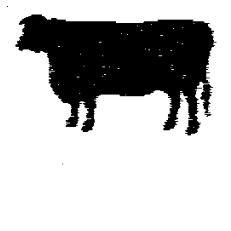

In [63]:
plt.imshow(img_save(y_tmm), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(path_save,f'{name_image}_{data}.png'),transparent=True,format='png', bbox_inches='tight', pad_inches=0)

## SVRNN

In [65]:
# Dimension of latent variables
z_dim = 1
h_dim = 14
num_neurons = 22
add_loss = True
#--------------------------------------------
model = SVRNN_2(x_dim, z_dim, h_dim, y_dim, num_neurons, device, add_loss)
# Save models
#--------------------------------------------
model.to(device)
print(f'{model.__class__.__name__ } has {num_param(model)} parameters to train' )
print(f'z_dim = {z_dim}, num_neurons = {num_neurons}, h_dim = {h_dim}')
data = model.__class__.__name__.casefold()
print(f'Actual path to save our models for {data} is \n {path_save} ')
# #* Initialization of the model in an specific epoch
model.to(device)
epoch_init = 100
model = model_reconstruction(model,epoch_init, path_save, device)


SVRNN_2 has 5240 parameters to train
z_dim = 1, num_neurons = 22, h_dim = 14
Actual path to save our models for svrnn_2 is 
 C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs\cow40 
Actual  path for to initialize our models:  C:\Users\kmorales\Google Drive\PhD\Simulations_semi_super\Results_outputs\cow40
Initialization of the SVRNN_2 model  at epoch 100
loss:  {tensor(-167833.3125, requires_grad=True)} and epoch:  {100}


In [66]:
# #* Reconstruction
y_ = model.reconstruction(x,y)
y_pred_m = y_[np.where(y1 == -1)].numpy()
y_true_m = y_true[np.where(y1 == -1)]
error_rate = 1-accuracy_score(y_true_m, y_pred_m)
print(f'{name_image}: {model.__class__.__name__ } with  {num_param(model)} parameters \n after {epoch_init} has an error rate of {error_rate}\n folder {data}' )
y_svrnn = y_.reshape(m,n).cpu().numpy()

cow40: SVRNN_2 with  5240 parameters 
 after 100 has an error rate of 0.16349795340652618
 folder svrnn_2


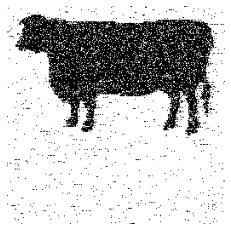

In [67]:

plt.imshow(img_save(y_svrnn), cmap='gray')
plt.axis('off')
plt.savefig(os.path.join(path_save,f'{name_image}_{data}.png'), transparent=True,format='png', bbox_inches='tight', pad_inches=0)